### In this file, we just repeat what we did in class_by_class.ipynb file multiple times to discover a more robust correlation between the entropy difference (of a subsample and its class) and the corresponding train/test set accuracy. However, we decide not to truncate the singular vector of the feature space and get BSIE value directly from it.

In [1]:
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split, DataLoader, SubsetRandomSampler, Subset, ConcatDataset
import os
from Truncate import truncate
from BSI_Entropy import BSIE
import numpy as np
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#### We first load in the Cifar-10 images and have all the classes/functions set up like before

In [2]:
data_dir = './data/cifar10'
training_dataset = ImageFolder(data_dir+'/train', transform=ToTensor())
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

In [3]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [5]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [6]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 64),
            nn.ReLU(),
            nn.Linear(64, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [7]:
device = get_default_device()
device

device(type='cpu')

#### Now we create a model object from the class and assign it trained parameters we saved before

In [8]:
modelCNN = to_device(Cifar10CnnModel(), device)

In [9]:
modelCNN.load_state_dict(torch.load('cifar10-cnn.pth')) # load our pretrained model parameters and assign to the new model object

<All keys matched successfully>

In [10]:
len(training_dataset), len(test_dataset) # make sure the number of images/labels in train and test set are correct

(50000, 10000)

In [11]:
from torch.utils.data.dataloader import DataLoader
batch_size=128
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
evaluate(modelCNN, test_loader)

{'val_loss': 0.9372484087944031, 'val_acc': 0.7689453363418579}

#### This following function helps us to attain intermediate feature in our embedding function which is the CNN we just created using the parameters we load in.

In [12]:
features = {}
def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()

    return hook

In [13]:
modelCNN.network[18].register_forward_hook(get_features('18'))

#### In the following code, we attain the intermediate feature space for each class in the training set

In [14]:
class_feature_data = {label: [] for label in range(10)}

In [15]:
for image, label in training_dataset:
    if label in class_feature_data:
        output = modelCNN(to_device(image.unsqueeze(0), device))
        class_feature_data[label].append(features['18'])

In [16]:
for label in class_feature_data:
    class_feature_data[label] = torch.cat(class_feature_data[label], dim = 0).T 

##### We then apply SVD to the feature space of each training class to attain singular vector. 

In [17]:
singular_vector = {label: torch.svd(class_feature_data[label])[1] for label in class_feature_data}
print(singular_vector)

{0: tensor([8305.8789, 1585.3182, 1073.5406,  963.0099,  828.8642,  769.5621,
         616.4266,  580.3412,  516.1616,  488.6954,  402.4275,  341.2084,
         275.5750,  266.5753,  257.8827,  231.7271,  198.1219,  183.4829,
         180.9243,  177.5941,  156.9813,  144.6703,  141.9810,  132.6933,
         126.5861,  122.6644,  117.9465,  113.8699,  110.0822,  106.3363,
         103.7124,   93.6782,   91.7617,   89.5256,   84.1956,   82.4179,
          80.3859,   78.2227,   75.4202,   72.8308,   71.0707,   69.9203,
          65.3629,   64.8393,   62.6921,   60.4378,   58.1620,   56.9152,
          54.7706,   54.1711,   52.7214,   51.6815,   50.4430,   49.4335,
          47.0124,   45.7740,   43.8802,   43.6093,   42.2480,   40.5315,
          39.1501,   37.6497,   36.0807,   34.7374]), 1: tensor([12095.2061,  1403.4337,  1103.4655,   963.6672,   940.5552,   853.0527,
          744.2352,   670.6514,   567.7023,   496.4117,   435.3126,   407.3419,
          350.2057,   277.2058,   250.3

#### Note here, we don't truncate singular vector anymore to get BSIE value because the singular vector of each training class feature space contains values apparently greater than 0 almost at each entry. 

In [18]:
entropy = {label: BSIE(singular_vector[label]).item() for label in singular_vector}
print(entropy)

{0: 0.06290901692797712, 1: 0.06283993894178475, 2: 0.06495570296841247, 3: 0.06314928805309994, 4: 0.06271682050760996, 5: 0.06349178769941977, 6: 0.06271585297092763, 7: 0.062195439924848994, 8: 0.06215472324653093, 9: 0.0626122551072612}


#### Now, we also want to test the performance of the original CNN model we trained with all our Cifar-10 training dataset(the embedding function) on the test set of each class and training set of each class:

In [19]:
classes = {0: (0, 5000), 1:(5000, 10000), 2:(10000, 15000), 3:(15000, 20000), 4:(20000, 25000), 5:(25000, 30000), 6:(30000, 35000), 7:(35000, 40000), 8:(40000, 45000), 9:(45000, 50000)}
training_data_by_class = {category: Subset(ImageFolder('./data/cifar10/train/', transform=ToTensor()), range(classes[category][0], classes[category][1])) for category in classes}


In [20]:
train_accu_by_class = {label: evaluate(modelCNN, DeviceDataLoader(DataLoader(training_data_by_class[label], batch_size*2), device))['val_acc'] for label in range(10)}
print(train_accu_by_class)


{0: 0.9573644399642944, 1: 0.958903968334198, 2: 0.9373161196708679, 3: 0.9092830419540405, 4: 0.9389591217041016, 5: 0.8896943926811218, 6: 0.9713580012321472, 7: 0.961638331413269, 8: 0.9748736619949341, 9: 0.9779986143112183}


##### Above is the original CNN model's performance on the training data of each class. We will also test its performance on the test set of each class below:

In [21]:
test_classes = {0: (0, 1000), 1:(1000, 2000), 2:(2000, 3000), 3:(3000, 4000), 4:(4000, 5000), 5:(5000, 6000), 6:(6000, 7000), 7:(7000, 8000), 8:(8000, 9000), 9:(9000, 10000)}
test_data_by_class = {category: Subset(ImageFolder('./data/cifar10/test/', transform=ToTensor()), range(test_classes[category][0], test_classes[category][1])) for category in test_classes}

In [23]:
test_accu_by_class = {label: evaluate(modelCNN, DeviceDataLoader(DataLoader(test_data_by_class[label], batch_size*2), device))['val_acc'] for label in range(10)}
print(test_accu_by_class)

{0: 0.8268453478813171, 1: 0.8339170217514038, 2: 0.6760169863700867, 3: 0.5890355706214905, 4: 0.711274266242981, 5: 0.6273572444915771, 6: 0.8606209754943848, 7: 0.8032732009887695, 8: 0.8591729402542114, 9: 0.8756734728813171}


In [19]:

def select_subsample(classified_training_data, n_sample = 500): 
    subsample = {i: random_split(classified_training_data[i], [n_sample, len(classified_training_data[i]) - n_sample])[0] for i in classified_training_data}
    return subsample

In [20]:
random_seed = 42
torch.manual_seed(random_seed);

    
val_size = 5000
train_size = len(training_dataset) - val_size

train_ds, val_ds = random_split(training_dataset, [train_size, val_size])


In [21]:
num_epochs = 15
opt_func = torch.optim.Adam
lr = 0.001

Epoch [0], train_loss: 2.2793, val_loss: 2.2826, val_acc: 0.1891
Epoch [1], train_loss: 2.0833, val_loss: 2.0292, val_acc: 0.2501
Epoch [2], train_loss: 1.9772, val_loss: 1.9202, val_acc: 0.2910
Epoch [3], train_loss: 1.8858, val_loss: 1.8891, val_acc: 0.3022
Epoch [4], train_loss: 1.8110, val_loss: 1.7992, val_acc: 0.3504
Epoch [5], train_loss: 1.7019, val_loss: 1.7757, val_acc: 0.3452
Epoch [6], train_loss: 1.6241, val_loss: 1.6574, val_acc: 0.3906
Epoch [7], train_loss: 1.5477, val_loss: 1.7318, val_acc: 0.3777
Epoch [8], train_loss: 1.4906, val_loss: 1.6906, val_acc: 0.3928
Epoch [9], train_loss: 1.4331, val_loss: 1.6168, val_acc: 0.4066
Epoch [10], train_loss: 1.3606, val_loss: 1.5777, val_acc: 0.4470
Epoch [11], train_loss: 1.3211, val_loss: 1.6990, val_acc: 0.4171
Epoch [12], train_loss: 1.2683, val_loss: 1.5414, val_acc: 0.4448
Epoch [13], train_loss: 1.1922, val_loss: 1.5715, val_acc: 0.4465
Epoch [14], train_loss: 1.0944, val_loss: 1.5704, val_acc: 0.4676
   class  Test_Accur

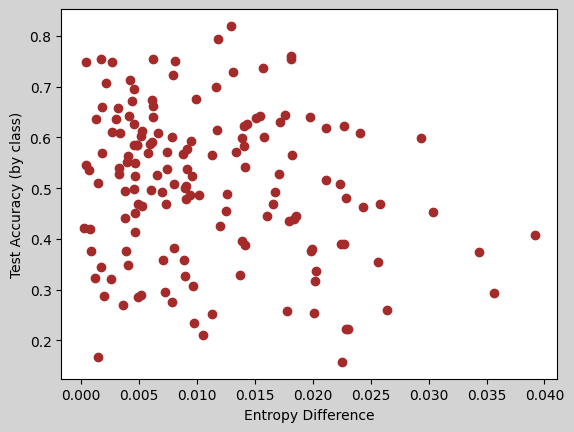

In [27]:
import time
fig, ax = plt.subplots(facecolor='lightgrey')
for i in range(15):
    subsample_500 = select_subsample(training_data_by_class)
    subset_feature = {category: [] for category in subsample_500}

    for category in subsample_500:
        for img, label in subsample_500[category]:
            output = modelCNN(to_device(img.unsqueeze(0), device))
            subset_feature[label].append(features['18'])
    for label in subset_feature:
        subset_feature[label] = torch.cat(subset_feature[label], dim = 0).T 
    subset_singular_vector = {label: torch.svd(subset_feature[label])[1] for label in subset_feature}
    # Here, we will compute the entropy value of each subset for each class
    subset_entropy = {label: BSIE(subset_singular_vector[label]).item() for label in subset_singular_vector}


    # Then we compute how much the subset entropy value deviates from the whole (training) set entropy value for each class
    # If, for example, the class 3 subset entropy value is close to the whole training set entropy value of class 3, then it means
    # the data structure of this subset is similar to the data structure of the whole class 3, so if this subset is a part of the 
    # whole training set, then the CNN trained on this training set is expected to perform well in classify the training data in class 3.
    # Furthermore, because of our assumption that the test set of class 3 shares a similar data structure as the data structure of the 
    # training set of class 3, the CNN model might also perform well on the test set of class 3. 


    entropy_diff = {label: np.abs(entropy[label] - subset_entropy[label])/entropy[label] for label in entropy}
    cifar10sub = ConcatDataset([subsample_500[class_name] for class_name in subsample_500])
    cifar10sub_loader = DataLoader(cifar10sub, batch_size = batch_size, shuffle = True, pin_memory = True)
    cifar10sub_train_loader = DeviceDataLoader(cifar10sub_loader, device)


    val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
    
    model = to_device(Cifar10CnnModel(), device)
    history = fit(num_epochs, lr, model, cifar10sub_train_loader, val_dl, opt_func)


    # We evaluate the CNN trained with combined subsets from each class on the training set of each class

    train_accuracy_by_class = {label: [] for label in training_data_by_class}

    for label in training_data_by_class:
        train_data = training_data_by_class[label]
        train_data_loader = DeviceDataLoader(DataLoader(train_data, batch_size*2), device)
        result = evaluate(model, train_data_loader)
        result
        train_accuracy_by_class[label] = result['val_acc']

    df1 = pd.DataFrame(list(train_accuracy_by_class.items()), columns=['class', 'Test_Accuracy']) # training set accuracy by class of this submodel

    
    df2 = pd.DataFrame(list(entropy_diff.items()), columns=['class', 'Entropy_difference'])
    merged_df = pd.merge(df1, df2, on='class')
    print(merged_df)
    plt.scatter(data=merged_df, x='Entropy_difference', y='Test_Accuracy', color = 'brown')
    fig.canvas.draw()
    fig.canvas.flush_events()
    time.sleep(0.1)

plt.xlabel('Entropy Difference')
plt.ylabel('Test Accuracy (by class)')   
plt.show()

Not finished yet, will update later this week. 

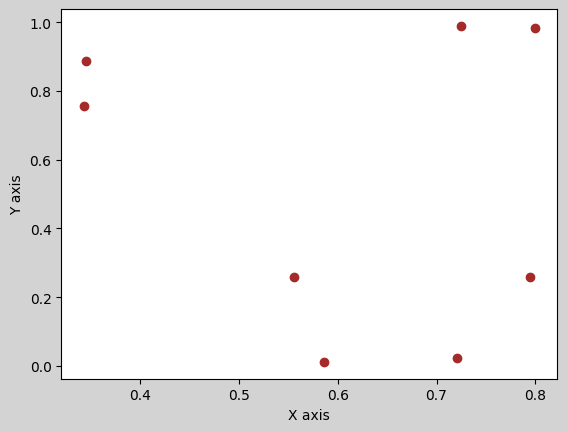

In [26]:
import time
fig, ax1 = plt.subplots(facecolor='lightgrey')
for i in range(2):
    y = np.random.rand(4)
    x = np.random.rand(4)
    df = pd.DataFrame({"xc": x, "yc": y})
    
    plt.scatter(x = "xc", y = "yc", data = df, color = 'brown')
    fig.canvas.draw()
    fig.canvas.flush_events()
    time.sleep(0.1)
    
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.show()